In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

In [2]:
d = 2
N = 20000

mu_0, sigma_0 = [-1.5] * int(N / 2), 0.8
mu_1, sigma_1 = [ 1.5] * int(N / 2), 0.8

In [3]:
data_0 = sigma_0 * np.random.randn(d, int(N / 2)) + mu_0
data_1 = sigma_1 * np.random.randn(d, int(N / 2)) + mu_1

labels_0 = [0] * int(N / 2)
labels_1 = [1] * int(N / 2)

In [4]:
data = np.concatenate((data_0.T, data_1.T))
labels = np.concatenate((labels_0, labels_1))

In [5]:
data = np.column_stack((data, labels))
np.random.shuffle(data)

In [6]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = np.column_stack((data.shape[0] * [1], data))
        self.labels = labels
        
    def __getitem__(self, idx):
        return torch.FloatTensor(self.data[idx]), torch.FloatTensor([self.labels[idx]])
    
    def __len__(self):
        return len(self.labels)
    
dataset = SimpleDataset(data[:,:2], data[:,2])

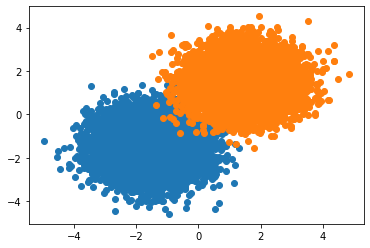

In [7]:
plt.scatter(data_0[0,:], data_0[1,:])
plt.scatter(data_1[0,:], data_1[1,:])
plt.show()

In [8]:
class Node():
    def __init__(self, data, lambda_ = 0):
        self.data = SimpleDataset(data[:,:2], data[:,2])
        self.c = data.shape[0]
        self.l = lambda_
        
n_nodes = 100
m = int(N / n_nodes)

nodes = []
for n in range(n_nodes):
    a,b = int(n * m), int((n+1) * m)
    nodes.append(Node(
        data[a:b],
        lambda_ = 1
    ))

In [110]:
class SimpleModel(torch.nn.Module):
    def __init__(self, length):
        super().__init__()
        self.length = length
        self.vector = torch.nn.Parameter(
            torch.tensor([-0.5] * length),
            requires_grad = True
        )
        self.vector.retain_grad = True
        
    def forward(self, x):
        x = torch.matmul(x, self.vector.reshape(self.length, -1))
        return torch.sigmoid(x)
    
    def save_model(self, name = 'simple_model.pth'):
        torch.save(self.state_dict(), name)
    
    def load_model(self, name = 'simple_model.pth'):
        self.load_state_dict(torch.load(name))
        
    def fit(self, dataloader, epochs):
        self.train()
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.0001, momentum=0.9)
        
        for i in range(epochs):
            for x,y in dataloader:
                x = self(x)
                loss = criterion(x, y)
                loss.backward()
                optimizer.step()
        
    def epoch_step(self, dataloader, model):
        self.train()
        criterion = torch.nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=0.0001, momentum=0.9)
        
       
        for x,y in dataloader:
            x = self(x)
            reg = models_diff(model, self)
            loss = criterion(x, y) + reg
            loss.backward()
            optimizer.step()
            
    def evaluate(self, dataloader):
        self.eval()
        acc = []
        with torch.no_grad():
            for x,y in dataloader:
                x = (self.forward(x) < 1/2)
                acc.append(torch.abs(y - x * 1).sum().item() / dataloader.batch_size)
        return np.mean(acc)

In [10]:
EPOCHS = 3

simple_model = SimpleModel(3)
simple_model.save_model()
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size = 4,
    shuffle = True,
    drop_last = True
)
simple_model.evaluate(dataloader)

0.019

## Normal Learning

In [11]:
simple_model.fit(dataloader, EPOCHS)
simple_model.evaluate(dataloader)

0.9956

## Federated Learning

### FedSGD

In [12]:
name = 'simple_fed_SDG.pth'

simple_model = SimpleModel(3)
simple_model.load_model()
simple_model.save_model(name)
simple_model.evaluate(dataloader)

0.019

In [13]:
agg_state_dict = None

for e in tqdm(range(EPOCHS)):
    total = sum([n.c for n in nodes])
    for node in nodes:
        simple_model.load_model(name = name)
        node_dataloader = torch.utils.data.DataLoader(
            node.data,
            batch_size = 4,
            shuffle = True,
            drop_last = True
        )
        simple_model.fit(node_dataloader, 1)
        if agg_state_dict is None:
            agg_state_dict = simple_model.state_dict()
            for key in agg_state_dict:
                agg_state_dict[key] = agg_state_dict[key] * node.c / total
        else:
            node_state_dict = simple_model.state_dict()
            for key in agg_state_dict:
                if agg_state_dict[key].requires_grad:
                    agg_state_dict[key] = agg_state_dict[key] + node_state_dict[key] * node.c / total
                
    simple_model.load_state_dict(agg_state_dict)
    simple_model.save_model(name)
    
simple_model.evaluate(dataloader)

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


0.98185

### FedAvg

In [14]:
name = 'simple_fed_AVG.pth'

simple_model = SimpleModel(3)
simple_model.load_model()
simple_model.save_model(name)
simple_model.evaluate(dataloader)

0.019

In [15]:
C = 0.7
avg_num = int(C * n_nodes)

for e in tqdm(range(EPOCHS)):
    current_nodes = np.array(nodes)[np.random.choice(n_nodes, avg_num)]
    total = sum([n.c for n in current_nodes])
    for node in current_nodes:
        simple_model.load_model(name = name)
        node_dataloader = torch.utils.data.DataLoader(
            node.data,
            batch_size = 4,
            shuffle = True,
            drop_last = True
        )
        simple_model.fit(node_dataloader, 3)
        if agg_state_dict is None:
            agg_state_dict = simple_model.state_dict()
        else:
            node_state_dict = simple_model.state_dict()
            for key in agg_state_dict:
                agg_state_dict[key] = agg_state_dict[key] + node_state_dict[key] * node.c / total
                
    simple_model.load_state_dict(agg_state_dict)
    simple_model.save_model(name)
    
simple_model.evaluate(dataloader)

100%|██████████| 3/3 [00:07<00:00,  2.43s/it]


0.99555

### LICCHAVI

In [119]:
name = 'licchavi_fed_SDG.pth'

simple_model = SimpleModel(3)
simple_model.load_model()
simple_model.save_model(name)
simple_model.evaluate(dataloader)

user_model = SimpleModel(3)

In [124]:
def models_diff(model1, model2, test = False):
    reg = torch.FloatTensor([0])
    reg.requires_grad = True
    if test:
        return reg
    for (name, w1) in model1.named_parameters():            
        if w1.requires_grad and 'bias' not in name:
            w2 = model2.state_dict()[name]
            reg = reg + torch.dist(w1, w2, 1) * node.l
    return reg

In [125]:
simple_model.evaluate(dataloader)

0.981

In [129]:
agg_state_dict = None
optimizer = torch.optim.SGD(simple_model.parameters(), lr=0.001, momentum=0.9)
for e in tqdm(range(EPOCHS)):
    #freeze general model
    for p in simple_model.parameters():
        p.requires_grad = False
        
    total = sum([n.c for n in nodes])
    # performs the nodes update
    for i, node in enumerate(nodes):
        user_modelname = f'user_models/user_{i}.pth'
        # loads the general model state
        simple_model.load_model(name = name)
        # loads the user model. If first epoch, takes the general model
        if e == 0:
            user_model.load_model(name = name)
        else:
            user_model.load_model(name = user_modelname)
        node_dataloader = torch.utils.data.DataLoader(
            node.data,
            batch_size = 4,
            shuffle = True,
            drop_last = True
        )
        user_model.epoch_step(node_dataloader, simple_model)
        user_model.save_model(user_modelname)
                
    #unfreeze general model
    for p in simple_model.parameters():
        p.requires_grad = True
    # computes the general model update
    optimizer.zero_grad()
    prev_grad = [0,0,0]
    for i, node in enumerate(nodes):
        user_modelname = f'user_models/user_{i}.pth'
        user_model.load_model(name = user_modelname)
        reg = models_diff(simple_model, user_model)
        reg.backward()
        
        for p in simple_model.parameters():
            current_grad = p.grad.cpu().numpy().copy()
            diff = current_grad - prev_grad
            prev_grad = current_grad
            print(diff)
        
    optimizer.step()
    simple_model.save_model(name)
    
simple_model.evaluate(dataloader)

 33%|███▎      | 1/3 [00:01<00:03,  1.56s/it]

[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -

 67%|██████▋   | 2/3 [00:03<00:01,  1.60s/it]

[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -

100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -1. -1.]
[-1. -

0.981

In [115]:
for p in simple_model.parameters():
    print(p.grad)

tensor([-11., -11., -11.])


In [154]:
c = torch.tensor([5.])

In [155]:
d = c

In [156]:
d = d + 1

In [157]:
c.cpu().numpy()

array([5.], dtype=float32)

In [152]:
d

tensor([6.], grad_fn=<AddBackward0>)